In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass
from typing import Tuple, Dict
import math
from pathlib import Path

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 30)


Anteprima Retail (prime 10 righe)


C:\Users\admloc\AppData\Local\Temp\ipykernel_5100\388004340.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = out.set_index("date").resample("M").last().dropna().reset_index()
C:\Users\admloc\AppData\Local\Temp\ipykernel_5100\388004340.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = out.set_index("date").resample("M").last().dropna().reset_index()


,date,volume
0,2003-01-31,318147.0
1,2003-02-28,323421.0
2,2003-03-31,326768.0
3,2003-04-30,331440.0
4,2003-05-31,329231.0
5,2003-06-30,335415.0
6,2003-07-31,334661.0
7,2003-08-31,329397.0
8,2003-09-30,334053.0
9,2003-10-31,335703.0



Anteprima Corporate (prime 10 righe)


,date,volume
0,2003-01-31,96065.0
1,2003-02-28,94946.0
2,2003-03-31,98017.0
3,2003-04-30,102425.0
4,2003-05-31,104693.0
5,2003-06-30,105451.0
6,2003-07-31,103573.0
7,2003-08-31,106073.0
8,2003-09-30,106850.0
9,2003-10-31,110454.0



Sintesi descrittiva iniziale (Retail & Corporate)


,serie,periodo_inizio,periodo_fine,osservazioni_mensili,media_volume,mediana_volume,min_volume,max_volume,freq_mensile_%_stimata
0,RETAIL,2003-01-31,2025-08-31,272,594486.507353,515440.5,318147.0,951914.0,100.0
1,CORPORATE,2003-01-31,2025-08-31,272,221810.889706,176685.5,94946.0,421143.0,100.0


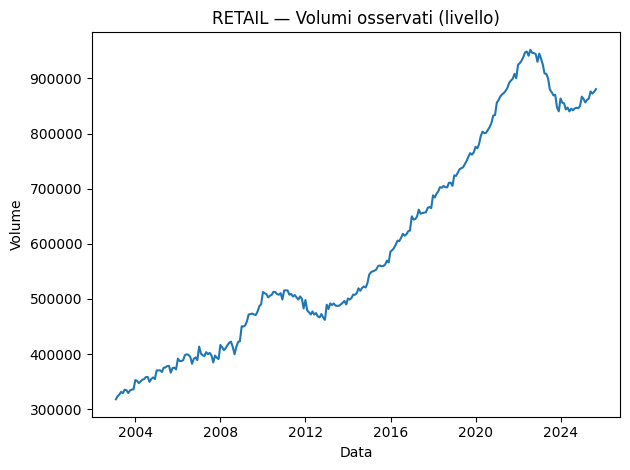

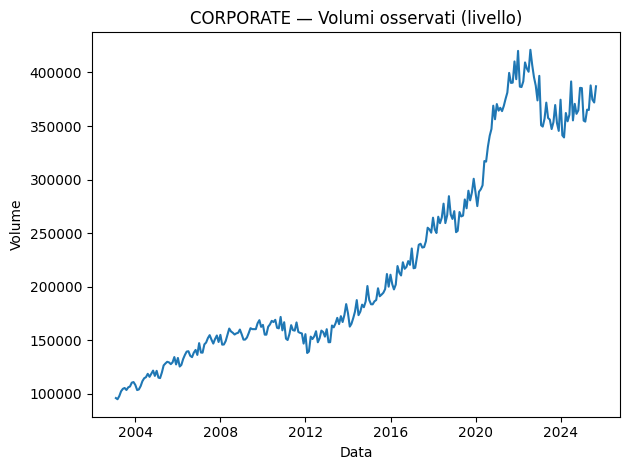

In [3]:
# Step 1: Caricamento e visualizzazione dei dati di partenza (Retail e Corporate)

def load_series(csv_path: str) -> pd.DataFrame:
    """
    Carica un CSV e prova a riconoscere automaticamente la colonna data e quella dei volumi.
    Restituisce un DataFrame con colonne: ['date', 'volume'] (mensile, ordinata, senza NA).
    """
    df = pd.read_csv(csv_path)


    # Il volume è sempre la terza colonna
    if df.shape[1] < 3:
        raise ValueError(f"Il file {csv_path} non contiene almeno 3 colonne; impossibile prendere la terza come volume.")
    vol_col = df.columns[2]
    
    date_col="DATE"

    out = df[[date_col, vol_col]].copy()
    out.columns = ["date","volume"]
    out["date"] = pd.to_datetime(out["date"])
    out = out.sort_values("date").dropna()
    out = out[out["volume"] > 0]

    # Normalizza a frequenza mensile (saldo di fine mese)
    out = out.set_index("date").resample("M").last().dropna().reset_index()
    return out

def describe_series(df: pd.DataFrame, name: str) -> pd.DataFrame:
    start = df["date"].min()
    end = df["date"].max()
    months = df.shape[0]
    gaps = df["date"].diff().dt.days.dropna()
    approx_month = ((gaps >= 28) & (gaps <= 31)).mean() * 100.0 if len(gaps) else np.nan
    stats = {
        "serie": [name],
        "periodo_inizio": [start],
        "periodo_fine": [end],
        "osservazioni_mensili": [months],
        "media_volume": [df["volume"].mean()],
        "mediana_volume": [df["volume"].median()],
        "min_volume": [df["volume"].min()],
        "max_volume": [df["volume"].max()],
        "freq_mensile_%_stimata": [approx_month]
    }
    return pd.DataFrame(stats)

def plot_series(df: pd.DataFrame, title: str):
    plt.figure()
    plt.plot(df["date"], df["volume"])
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()

# --- Caricamento dati ---

# Percorsi relativi rispetto alla posizione del notebook
RETAIL_PATH = Path("Retail CSV.csv")
CORPORATE_PATH = Path("Corporate CSV.csv") 

# Caricamento dati con percorsi relativi
retail_df = load_series(RETAIL_PATH)
corporate_df = load_series(CORPORATE_PATH)

# --- Anteprime ---
print("\nAnteprima Retail (prime 10 righe)")
display(retail_df.head(10))
print("\nAnteprima Corporate (prime 10 righe)")
display(corporate_df.head(10))

# --- Descrittive ---
summary_df = pd.concat([
    describe_series(retail_df, "RETAIL"),
    describe_series(corporate_df, "CORPORATE")
], ignore_index=True)
print("\nSintesi descrittiva iniziale (Retail & Corporate)")
display(summary_df)

# --- Grafici ---
plot_series(retail_df, "RETAIL — Volumi osservati (livello)")
plot_series(corporate_df, "CORPORATE — Volumi osservati (livello)")


Media geometrica — Retail: 564159.01
Media geometrica — Corporate: 203310.84

Retail — prime 12 righe con v_log e y_t


,date,volume,v_log,y_t
0,2003-01-31,318147.0,12.670269,-0.572823
1,2003-02-28,323421.0,12.686710,-0.556381
2,2003-03-31,326768.0,12.697006,-0.546086
3,2003-04-30,331440.0,12.711202,-0.531889
4,2003-05-31,329231.0,12.704515,-0.538577
5,2003-06-30,335415.0,12.723124,-0.519968
6,2003-07-31,334661.0,12.720873,-0.522218
7,2003-08-31,329397.0,12.705019,-0.538072
8,2003-09-30,334053.0,12.719055,-0.524036
9,2003-10-31,335703.0,12.723982,-0.519109



Corporate — prime 12 righe con v_log e y_t


,date,volume,v_log,y_t
0,2003-01-31,96065.0,11.472780,-0.749711
1,2003-02-28,94946.0,11.461064,-0.761428
2,2003-03-31,98017.0,11.492896,-0.729595
3,2003-04-30,102425.0,11.536886,-0.685605
4,2003-05-31,104693.0,11.558788,-0.663704
5,2003-06-30,105451.0,11.566002,-0.656490
6,2003-07-31,103573.0,11.548032,-0.674459
7,2003-08-31,106073.0,11.571883,-0.650608
8,2003-09-30,106850.0,11.579181,-0.643310
9,2003-10-31,110454.0,11.612354,-0.610137


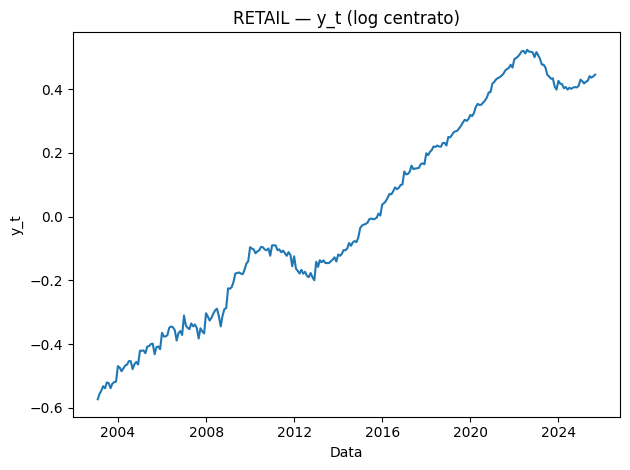

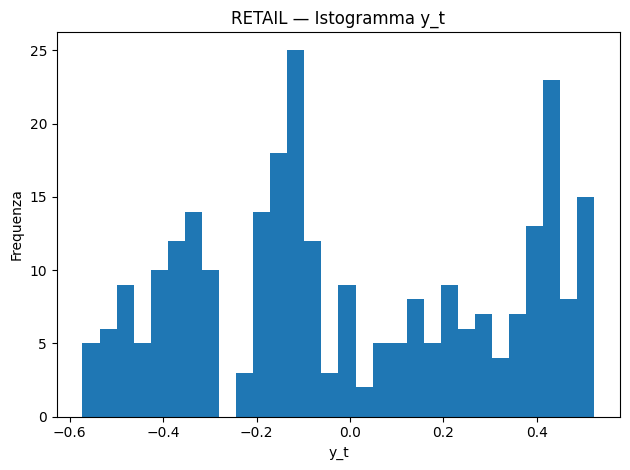

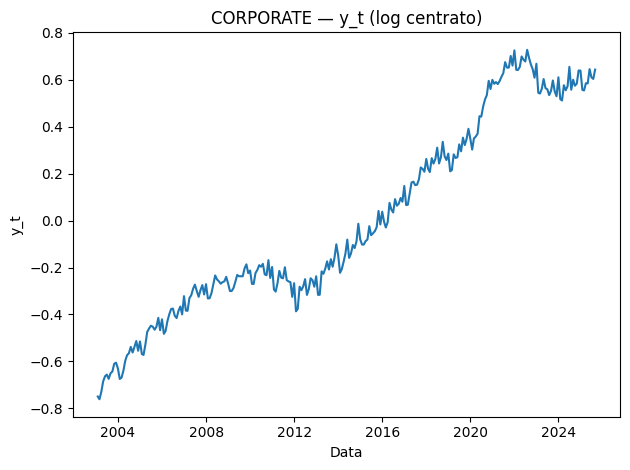

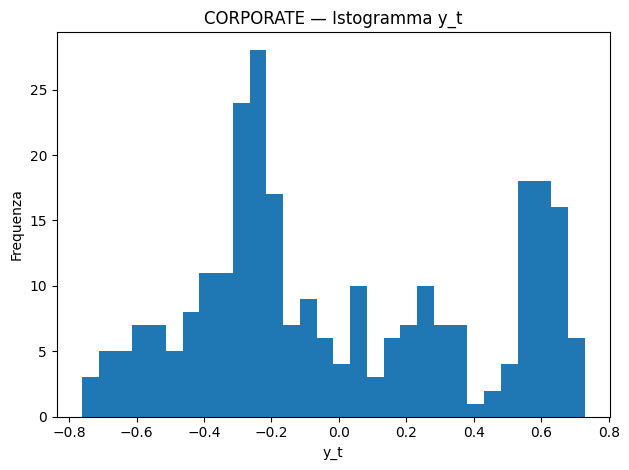

In [4]:
def build_log_centered(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggiunge v_log = log(volume) e y_t = v_log - mean(v_log).
    Salva in df.attrs:
      - 'vbar' = media di v_log
      - 'geom_mean_level' = exp(vbar)
    """
    out = df.copy()
    out["v_log"] = np.log(out["volume"].astype(float))
    vbar = out["v_log"].mean()
    out["y_t"] = out["v_log"] - vbar
    out.attrs["vbar"] = float(vbar)
    out.attrs["geom_mean_level"] = float(np.exp(vbar))
    return out


# --- Trasformazione e centratura ---
retail_step2 = build_log_centered(retail_df)
corporate_step2 = build_log_centered(corporate_df)


# --- Riepilogo: media geometrica ---
print("Media geometrica — Retail:", f"{retail_step2.attrs['geom_mean_level']:.2f}")
print("Media geometrica — Corporate:", f"{corporate_step2.attrs['geom_mean_level']:.2f}")

# --- Ispezione delle nuove colonne ---
print("\nRetail — prime 12 righe con v_log e y_t")
display(retail_step2.head(12))
print("\nCorporate — prime 12 righe con v_log e y_t")
display(corporate_step2.head(12))

# --- Grafici diagnostici: y_t nel tempo e istogramma ---
def plot_centered_series(df_centered: pd.DataFrame, title_prefix: str):
    # y_t nel tempo
    plt.figure()
    plt.plot(df_centered["date"], df_centered["y_t"])
    plt.title(f"{title_prefix} — y_t (log centrato)")
    plt.xlabel("Data"); plt.ylabel("y_t")
    plt.tight_layout(); plt.show()

    # istogramma di y_t
    plt.figure()
    plt.hist(df_centered["y_t"].dropna(), bins=30)
    plt.title(f"{title_prefix} — Istogramma y_t")
    plt.xlabel("y_t"); plt.ylabel("Frequenza")
    plt.tight_layout(); plt.show()

plot_centered_series(retail_step2, "RETAIL")
plot_centered_series(corporate_step2, "CORPORATE")

Iter   1 — beta=0.983793, Q=2.884312e-03, R=8.439525e-03, rel_change=7.681e-02
Iter   2 — beta=0.987948, Q=2.130752e-03, R=2.475219e-03, rel_change=7.428e-03
Iter   3 — beta=0.991709, Q=1.295862e-03, R=1.095786e-03, rel_change=4.141e-03
Iter  20 — beta=0.996973, Q=1.638112e-04, R=4.513377e-05, rel_change=7.623e-06
Iter  40 — beta=0.996907, Q=1.751016e-04, R=3.650107e-05, rel_change=1.565e-06
Iter  60 — beta=0.996889, Q=1.781758e-04, R=3.435354e-05, rel_change=5.179e-07
Iter  80 — beta=0.996883, Q=1.792724e-04, R=3.360649e-05, rel_change=1.951e-07
Iter  95 — beta=0.996881, Q=1.796242e-04, R=3.336891e-05, rel_change=9.691e-08

RETAIL — Parametri stimati:
  beta (AR1)    = 0.996881
  Q (state var) = 1.796242e-04
  R (meas var)  = 3.336891e-05
  theta (OU)    = 0.037488  (se definito per beta>0)


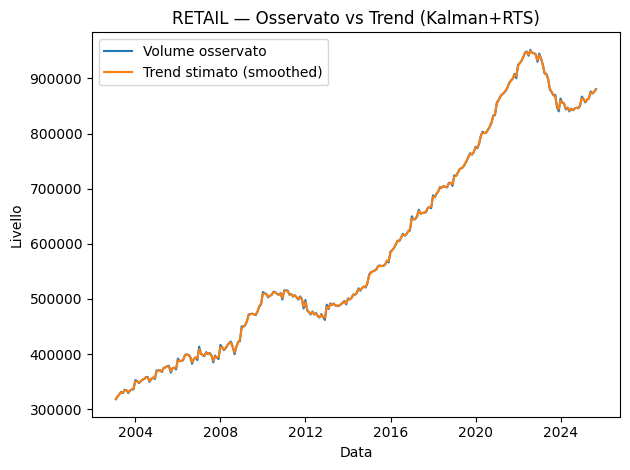

Iter   1 — beta=0.984015, Q=4.711432e-03, R=1.455130e-02, rel_change=1.154e-01
Iter   2 — beta=0.988053, Q=3.558402e-03, R=4.585413e-03, rel_change=1.099e-02
Iter   3 — beta=0.991426, Q=2.341760e-03, R=2.223308e-03, rel_change=4.346e-03
Iter  20 — beta=0.996515, Q=5.908264e-04, R=5.408789e-04, rel_change=4.178e-06
Iter  40 — beta=0.996539, Q=5.828121e-04, R=5.468737e-04, rel_change=2.577e-07
Iter  47 — beta=0.996540, Q=5.824849e-04, R=5.471192e-04, rel_change=9.692e-08

CORPORATE — Parametri stimati:
  beta (AR1)    = 0.996540
  Q (state var) = 5.824849e-04
  R (meas var)  = 5.471192e-04
  theta (OU)    = 0.041591  (se definito per beta>0)


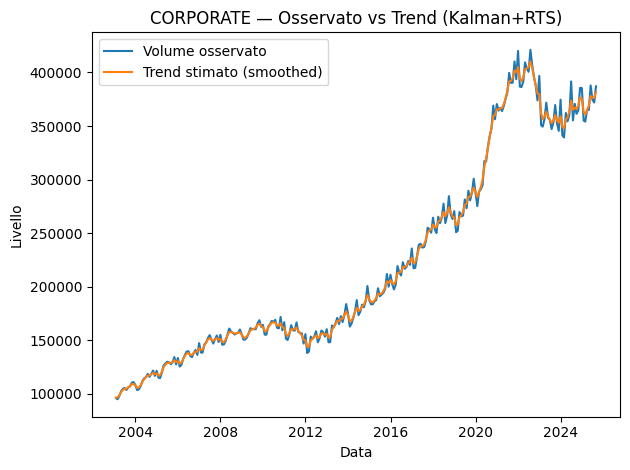

In [5]:
# --- Modello in spazio degli stati: definizioni ---

@dataclass
class SSMParams:
    beta: float   # coefficiente AR(1) nello stato
    Q: float      # varianza del rumore di stato
    R: float      # varianza del rumore di misura

@dataclass
class SSMResults:
    params: SSMParams
    xs: np.ndarray      # E[s_t | Y_1:T] (smoothed states)
    Ps: np.ndarray      # Var(s_t | Y_1:T)
    Pcs: np.ndarray     # Cov(s_t, s_{t-1} | Y_1:T)

def kalman_filter(y: np.ndarray, params: SSMParams):
    T = len(y)
    beta, Q, R = params.beta, params.Q, params.R
    x_pred = np.zeros(T); P_pred = np.zeros(T)
    x_filt = np.zeros(T); P_filt = np.zeros(T)

    # inizializzazione stazionaria dell'AR(1)
    x0 = 0.0
    P0 = Q / (1 - beta**2 + 1e-12)
    xp, Pp = x0, P0

    for t in range(T):
        # update
        S = Pp + R
        K = Pp / (S + 1e-12)
        xf = xp + K * (y[t] - xp)
        Pf = (1 - K) * Pp

        x_filt[t] = xf; P_filt[t] = Pf

        # predict
        xp = beta * xf
        Pp = beta**2 * Pf + Q
        x_pred[t] = xp; P_pred[t] = Pp

    return x_pred, P_pred, x_filt, P_filt


def ou_from_ar1(beta: float, Q: float, delta: float = 1/12) -> Dict[str, float]:
    """
    Parametri OU equivalenti (tempo continuo) — utile per interpretazione:
      theta = -ln(beta)/Δ , sigma_s^2 = Q * 2*theta / (1 - exp(-2*theta*Δ))
    Valido per beta>0.
    """
    beta = float(np.clip(beta, -0.999, 0.999))
    if beta <= 0:
        return {"theta": np.nan, "sigma_s": np.nan}
    theta = -math.log(max(beta, 1e-9)) / delta
    sigma_s_sq = Q * (2*theta) / (1 - math.exp(-2*theta*delta) + 1e-12)
    return {"theta": theta, "sigma_s": math.sqrt(max(sigma_s_sq, 0.0))}
# --- PATCH: smoother con lag-uno esatto + EM che lo usa ---

def rts_smoother_exact(y, params, x_pred, P_pred, x_filt, P_filt, K):
    """
    Ricorrenze Holmes/Harvey per il lag-uno smussato.
    x_pred[t], P_pred[t] = predizione per (t+1|t).
    """
    T = len(y)
    beta = params.beta

    xs = np.copy(x_filt)
    Ps = np.copy(P_filt)
    Pcs = np.full(T, np.nan)  # P_{t,t-1|T} per t>=1

    # smoother gain J_t = P_{t|t} A' (P_{t+1|t})^{-1}
    J = np.zeros(T-1)
    for t in range(T-1):
        J[t] = P_filt[t] * beta / (P_pred[t] + 1e-12)

    # Passata all'indietro per xs, Ps (corretto indexing: usa P_pred[t], non P_pred[t+1])
    for t in range(T-2, -1, -1):
        xs[t] = x_filt[t] + J[t] * (xs[t+1] - x_pred[t])
        Ps[t] = P_filt[t] + (J[t]**2) * (Ps[t+1] - P_pred[t])

    # Lag-uno: inizializzazione al bordo
    if T >= 2:
        Pcs[T-1] = (1.0 - K[T-1]) * beta * P_filt[T-2]

        # Ricorrenza esatta: t = T-2 ... 1
        for t in range(T-2, 0, -1):
            Jt    = J[t]
            Jt_1  = J[t-1]
            Pcs[t] = P_filt[t] * Jt_1 + Jt * (Pcs[t+1] - beta * P_filt[t]) * Jt_1

    return xs, Ps, Pcs

def em_step_exact(y: np.ndarray, params: SSMParams):
    # Filtro con K salvato
    x_pred, P_pred, x_filt, P_filt = kalman_filter(y, params)  # usa il tuo filtro
    # ricostruisco K_t dalla fase di update: K_t = P_{t|t-1} / (P_{t|t-1} + R)
    # P_{t|t-1} è "la predizione che porta a t": per coerenza con il filtro sopra,
    # P_pred[t-1] = P_{t|t-1}. Per t=0, usiamo la inizializzazione stazionaria.
    K = np.zeros_like(y, dtype=float)
    # inizializzazione stazionaria del primo passo
    P0 = params.Q / (1 - params.beta**2 + 1e-12)
    S0 = P0 + params.R
    K[0] = P0 / (S0 + 1e-12)
    for t in range(1, len(y)):
        Ptt_1 = P_pred[t-1]  # = P_{t|t-1}
        K[t] = Ptt_1 / (Ptt_1 + params.R + 1e-12)

    xs, Ps, Pcs = rts_smoother_exact(y, params, x_pred, P_pred, x_filt, P_filt, K)

    # Momenti attesi per lo Step-M
    Exx      = Ps + xs**2
    Exx_prev = Exx[:-1]
    Exx_curr = Exx[1:]
    Exx1     = (xs[1:] * xs[:-1]) + Pcs[1:]   # <-- usa lag-uno esatto

    beta_new = (np.nansum(Exx1)) / (np.nansum(Exx_prev) + 1e-12)
    Q_new    = (np.nansum(Exx_curr) - 2*beta_new*np.nansum(Exx1) + (beta_new**2)*np.nansum(Exx_prev)) / (len(y)-1 + 1e-12)
    R_new    = (np.sum(y**2) - 2*np.sum(y*xs) + np.sum(Exx)) / (len(y) + 1e-12)

    beta_new = float(np.clip(beta_new, -0.999, 0.999))
    Q_new    = float(max(Q_new, 1e-12))
    R_new    = float(max(R_new, 1e-12))

    return SSMParams(beta_new, Q_new, R_new), (xs, Ps, Pcs)

def em_fit_exact(y: np.ndarray, max_iter: int = 300, tol: float = 1e-7, verbose: bool = True) -> SSMResults:
    y = np.asarray(y, dtype=float)
    y = y - np.mean(y)

    var_y = float(np.var(y))
    params = SSMParams(beta=0.95, Q=0.3*var_y*(1-0.95**2 + 1e-12), R=0.7*var_y)

    last = np.array([params.beta, params.Q, params.R], dtype=float)
    xs = Ps = Pcs = None
    for it in range(1, max_iter+1):
        params, eout = em_step_exact(y, params)
        xs, Ps, Pcs = eout
        cur = np.array([params.beta, params.Q, params.R], dtype=float)
        rel = np.linalg.norm(cur - last) / (np.linalg.norm(last) + 1e-12)
        if verbose and (it <= 3 or it % 20 == 0 or rel < tol):
            print(f"Iter {it:3d} — beta={params.beta:.6f}, Q={params.Q:.6e}, R={params.R:.6e}, rel_change={rel:.3e}")
        if rel < tol:
            break
        last = cur
    return SSMResults(params=params, xs=xs, Ps=Ps, Pcs=Pcs)



# --- Funzione helper per stimare e graficare una serie ---
def estimate_and_plot(df_centered: pd.DataFrame, name: str):
    y = df_centered["y_t"].values.astype(float)
    vbar = df_centered.attrs["vbar"]

    res = em_fit_exact(y, max_iter=300, tol=1e-7, verbose=True)
    ou = ou_from_ar1(res.params.beta, res.params.Q, delta=1/12)

    print(f"\n{name} — Parametri stimati:")
    print(f"  beta (AR1)    = {res.params.beta:.6f}")
    print(f"  Q (state var) = {res.params.Q:.6e}")
    print(f"  R (meas var)  = {res.params.R:.6e}")
    print(f"  theta (OU)    = {ou['theta']:.6f}  (se definito per beta>0)")

    # Trend stimato in livello: exp(vbar + xs)
    trend_level = np.exp(vbar + res.xs)

    df_plot = df_centered[["date","volume"]].copy()
    df_plot["trend_level"] = trend_level

    # Grafico: osservato vs trend stimato
    plt.figure()
    plt.plot(df_plot["date"], df_plot["volume"], label="Volume osservato")
    plt.plot(df_plot["date"], df_plot["trend_level"], label="Trend stimato (smoothed)")
    plt.title(f"{name} — Osservato vs Trend (Kalman+RTS)")
    plt.xlabel("Data"); plt.ylabel("Livello"); plt.legend()
    plt.tight_layout(); plt.show()

    return res, ou, df_plot

# --- Stima per Retail e Corporate ---
retail_res, retail_ou, retail_plotdf = estimate_and_plot(retail_step2, "RETAIL")
corporate_res, corporate_ou, corporate_plotdf = estimate_and_plot(corporate_step2, "CORPORATE")

In [6]:
# === PATCH: SD, t-value e p-value per (beta, Q, R) via Hessiano numerico ===
import numpy as np
import pandas as pd
from numpy.linalg import inv
from scipy.stats import norm

# Log-verosimiglianza (metodo delle innovazioni) data y e params correnti
def kalman_loglik(y: np.ndarray, params: SSMParams) -> float:
    beta, Q, R = params.beta, params.Q, params.R
    # init stazionaria
    x = 0.0
    P = Q / (1 - beta**2 + 1e-12)
    ll = 0.0
    for t in range(len(y)):
        S = P + R
        v = y[t] - x               # innovazione
        ll += -0.5 * (np.log(2*np.pi*S) + (v*v)/S)
        K = P / (S + 1e-12)
        x = x + K * v              # update
        P = (1 - K) * P
        # predict
        x = beta * x
        P = beta**2 * P + Q
    return float(ll)

# Trasformazioni: spazio non vincolato <-> parametri
def pack_params_unconstrained(params: SSMParams) -> np.ndarray:
    # beta in (-1,1) -> atanh; Q,R > 0 -> log
    b = np.clip(params.beta, -0.999999, 0.999999)
    return np.array([np.arctanh(b), np.log(params.Q), np.log(params.R)], dtype=float)

def unpack_params_unconstrained(z: np.ndarray) -> SSMParams:
    beta = float(np.tanh(z[0]))
    Q = float(np.exp(z[1]))
    R = float(np.exp(z[2]))
    return SSMParams(beta=beta, Q=Q, R=R)

# Hessiano numerico centrato della log-likelihood in spazio non vincolato
def numerical_hessian_loglik(y: np.ndarray, z_hat: np.ndarray, eps: np.ndarray = None) -> np.ndarray:
    k = len(z_hat)
    if eps is None:
        eps = np.array([1e-5, 1e-5, 1e-5], dtype=float)
    H = np.zeros((k, k), dtype=float)
    # funzione in z
    def f(z):
        return kalman_loglik(y, unpack_params_unconstrained(z))
    f00 = f(z_hat)
    # elementi diagonali e off-diagonali (schema a 4/5 punti)
    for i in range(k):
        e_i = np.zeros(k); e_i[i] = eps[i]
        fpp = f(z_hat + e_i)      # f(z+ei)
        fmm = f(z_hat - e_i)      # f(z-ei)
        # derivata seconda ~ (f(z+ei) - 2f(z) + f(z-ei)) / eps^2
        H[i, i] = (fpp - 2*f00 + fmm) / (eps[i]**2)
        for j in range(i+1, k):
            e_j = np.zeros(k); e_j[j] = eps[j]
            fpp = f(z_hat + e_i + e_j)
            fpm = f(z_hat + e_i - e_j)
            fmp = f(z_hat - e_i + e_j)
            fmm = f(z_hat - e_i - e_j)
            # misto ~ (f(+,+) - f(+,-) - f(-,+) + f(-,-)) / (4 eps_i eps_j)
            H_ij = (fpp - fpm - fmp + fmm) / (4.0 * eps[i] * eps[j])
            H[i, j] = H_ij
            H[j, i] = H_ij
    return H  # Hessiano della log-likelihood (≈ ∂²ℓ/∂z²)

# Varianza asintotica via informazione osservata e Delta method
def sandwich_cov_params(y: np.ndarray, params_hat: SSMParams) -> (np.ndarray, np.ndarray):
    # Hessiano in spazio non vincolato
    z_hat = pack_params_unconstrained(params_hat)
    H = numerical_hessian_loglik(y, z_hat)
    # informazione osservata ~ -H
    I = -H
    # controllo invertibilità
    cov_z = inv(I + 1e-12*np.eye(I.shape[0]))
    # Jacobiano della trasformazione inversa z -> theta = (beta, Q, R)
    beta, Q, R = params_hat.beta, params_hat.Q, params_hat.R
    J = np.diag([1 - beta**2, Q, R])  # d beta/dz = 1 - beta^2 ; dQ/dz = Q ; dR/dz = R
    cov_theta = J @ cov_z @ J.T
    sd_theta = np.sqrt(np.maximum(np.diag(cov_theta), 0.0))
    return cov_theta, sd_theta

# Tabella riassuntiva con EST, SD, t-value e p-value
def summarize_params(y: np.ndarray, res: SSMResults, name: str, alpha: float = 0.05) -> pd.DataFrame:
    est = np.array([res.params.R, res.params.beta, res.params.Q], dtype=float)
    labels = ["R (σ_ε²)", "β", "Q (σ_w²)"]
    _, sd = sandwich_cov_params(y, res.params)
    sd_ordered = np.array([sd[2], sd[0], sd[1]])  # mappo su (R, beta, Q)
    tvals = est / sd_ordered
    pvals = 2*(1 - norm.cdf(np.abs(tvals)))
    df = pd.DataFrame({
        "NAME": labels,
        "EST": est,
        "SD": sd_ordered,
        "TS": tvals,
        "PV": pvals
    })
    print(f"\nParametri — {name}")
    display(df)
    return df

# === ESECUZIONE: calcolo SD/TS/PV per Retail & Corporate (usando i risultati già stimati) ===
retail_stats = summarize_params(retail_step2["y_t"].values.astype(float), retail_res, "Retail")
corporate_stats = summarize_params(corporate_step2["y_t"].values.astype(float), corporate_res, "Corporate")



Parametri — Retail


,NAME,EST,SD,TS,PV
0,R (σ_ε²),0.000033,0.000013,2.563609,1.035903e-02
1,β,0.996881,0.001228,812.096976,0.000000e+00
2,Q (σ_w²),0.000180,0.000027,6.770319,1.284994e-11



Parametri — Corporate


,NAME,EST,SD,TS,PV
0,R (σ_ε²),0.000547,0.000096,5.698706,1.207201e-08
1,β,0.996540,0.001786,558.044292,0.000000e+00
2,Q (σ_w²),0.000582,0.000116,5.015444,5.291107e-07



=== RETAIL — significance 90.0% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,873695.187137,0.007873,0.9,0.996881,0.00018


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.00000,0.000000,0.000000,873695.187137
1,1,0.018225,0.018225,0.00005,0.018275,0.018275,857645.983025
2,2,0.017835,0.036059,0.00005,0.017884,0.036159,841940.279458
3,3,0.017454,0.053513,0.00005,0.017504,0.053663,826569.837052
12,12,0.014410,0.194894,0.00005,0.014460,0.195492,702065.746900
24,24,0.011240,0.346328,0.00005,0.011290,0.347523,568709.398570
36,36,0.008835,0.464926,0.00005,0.008885,0.466718,464268.500193
48,48,0.006997,0.558519,0.00005,0.007047,0.560909,381847.866076
60,60,0.005582,0.632923,0.00005,0.005631,0.635910,316325.756220


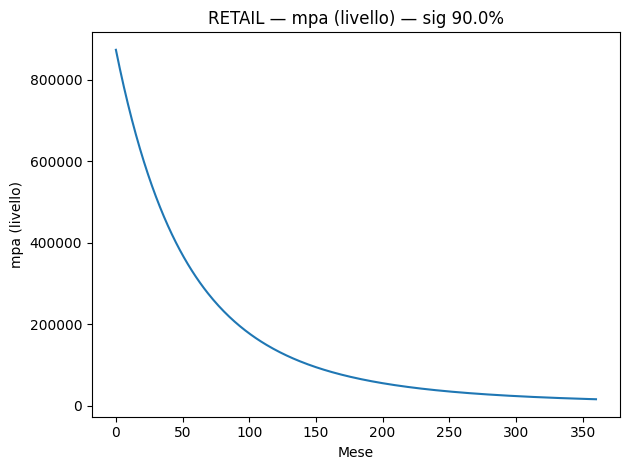

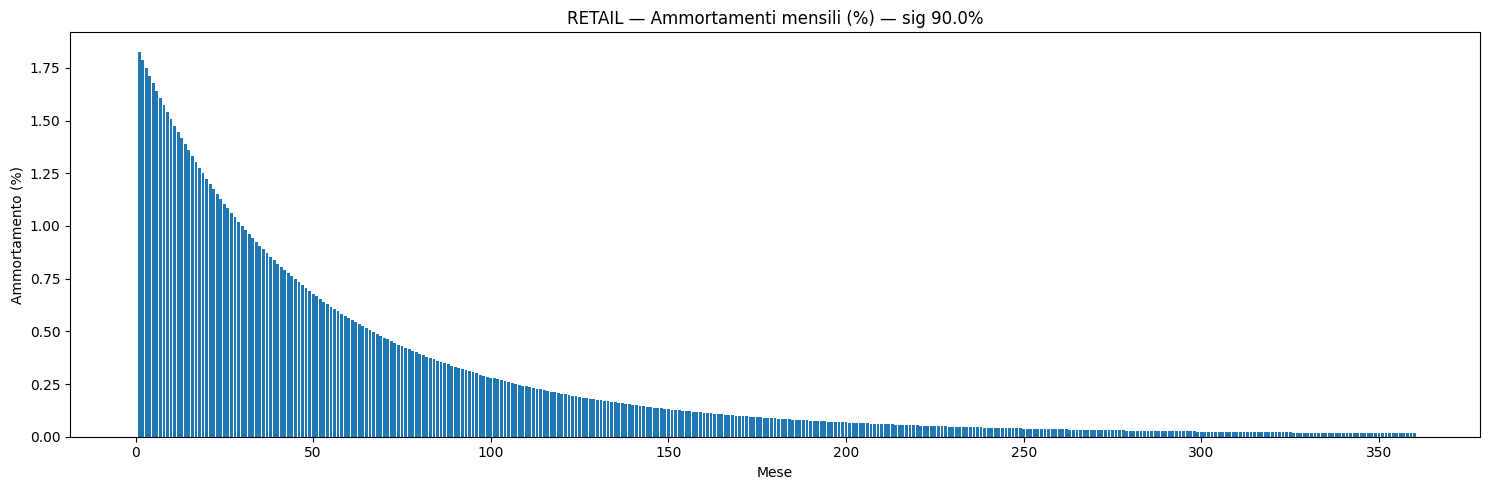


=== RETAIL — significance 95.0% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,871994.369277,0.009804,0.95,0.996881,0.00018


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,871994.369277
1,1,0.022905,0.022905,0.000017,0.022922,0.022922,851823.866196
2,2,0.022306,0.045211,0.000017,0.022323,0.045245,832180.681251
3,3,0.021724,0.066935,0.000017,0.021742,0.066987,813049.634436
12,12,0.017183,0.238875,0.000017,0.017200,0.239083,661634.158233
24,24,0.012681,0.414304,0.000017,0.012698,0.414720,507146.705286
36,36,0.009451,0.544431,0.000017,0.009468,0.545055,392553.121504
48,48,0.007110,0.641888,0.000017,0.007127,0.642720,306729.859477
60,60,0.005398,0.715556,0.000017,0.005415,0.716597,241855.450658


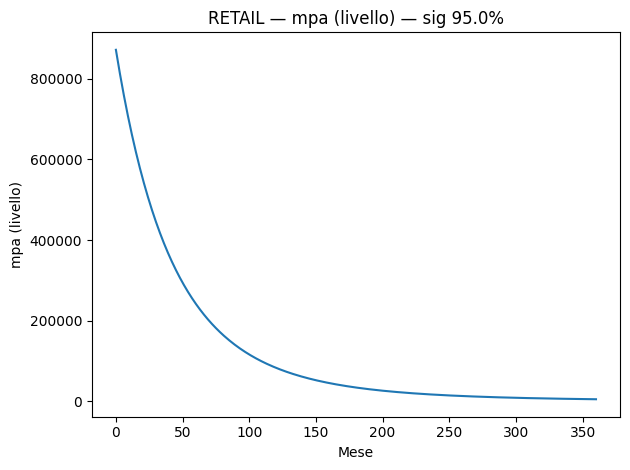

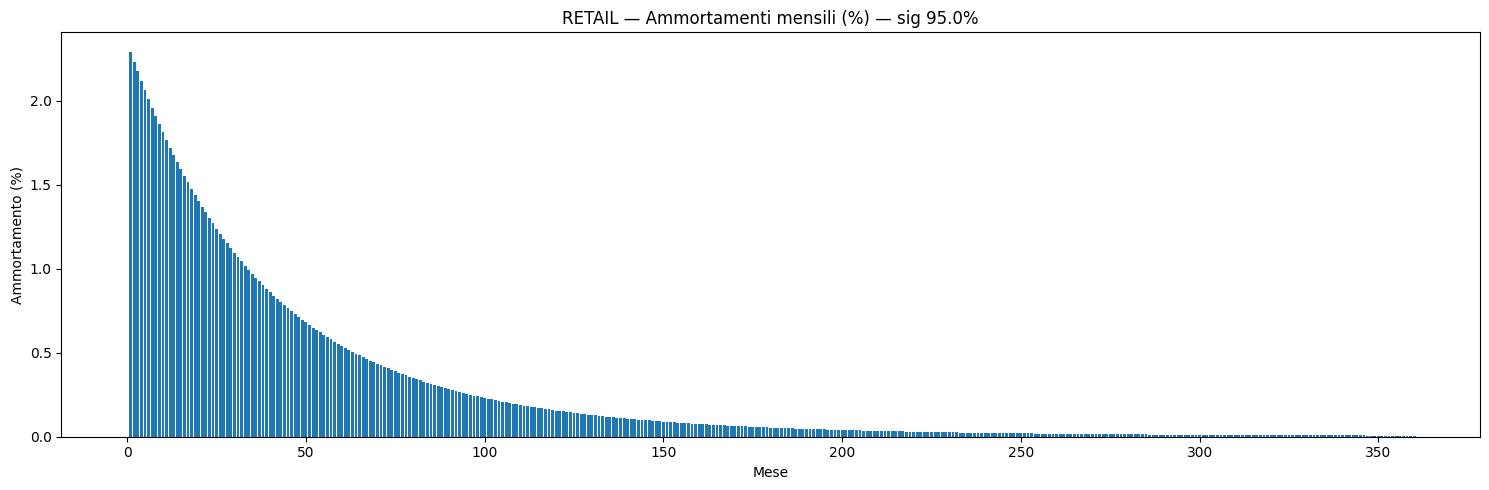


=== RETAIL — significance 99.0% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,868812.84342,0.013417,0.99,0.996881,0.00018


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,868812.843420
1,1,0.031573,0.031573,0.000002,0.031575,0.031575,841008.938026
2,2,0.030469,0.062041,0.000002,0.030471,0.062046,814177.413188
3,3,0.029406,0.091447,0.000002,0.029408,0.091455,788281.639064
12,12,0.021461,0.314374,0.000002,0.021463,0.314403,591965.904590
24,24,0.014276,0.522062,0.000002,0.014279,0.522120,409070.472093
36,36,0.009627,0.661187,0.000002,0.009630,0.661273,286553.003232
48,48,0.006578,0.755639,0.000002,0.006580,0.755754,203376.096497
60,60,0.004551,0.820594,0.000002,0.004554,0.820737,146175.191756


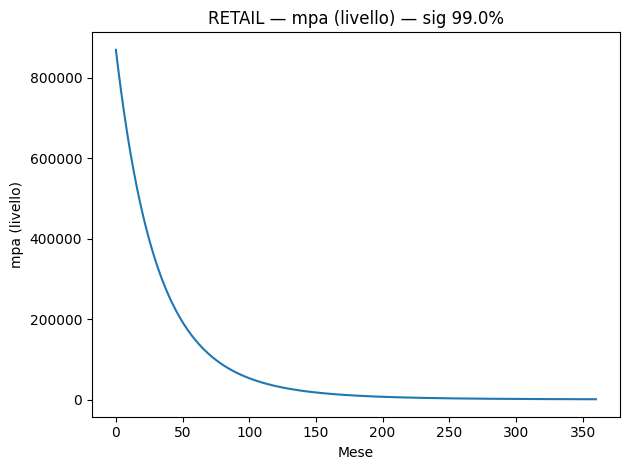

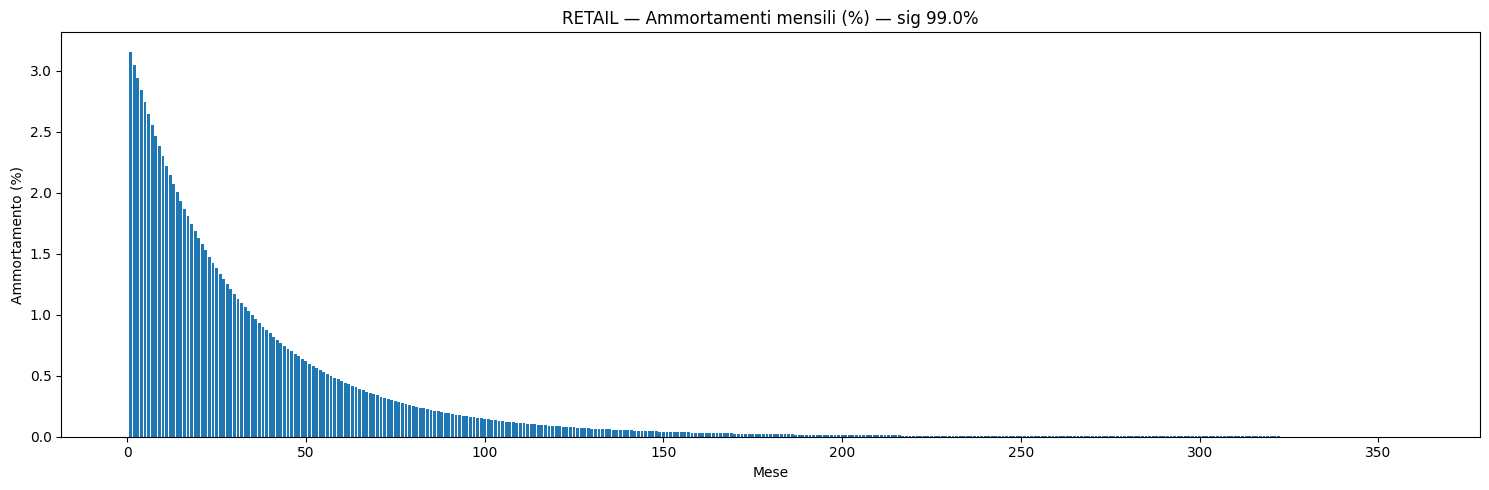


=== RETAIL — significance 99.9% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,865260.478458,0.017451,0.999,0.996881,0.00018


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,865260.478458
1,1,0.041119,0.041119,2.610968e-07,0.041120,0.041120,829049.652603
2,2,0.039278,0.080398,2.610968e-07,0.039278,0.080398,794460.165991
3,3,0.037525,0.117922,2.610968e-07,0.037525,0.117923,761415.023861
12,12,0.025024,0.389158,2.610968e-07,0.025024,0.389161,522556.924887
24,24,0.014818,0.617471,2.610968e-07,0.014818,0.617477,321498.339849
36,36,0.008933,0.753888,2.610968e-07,0.008933,0.753897,201365.817001
48,48,0.005479,0.836844,2.610968e-07,0.005479,0.836856,128312.526839
60,60,0.003417,0.888152,2.610968e-07,0.003417,0.888167,83129.195691


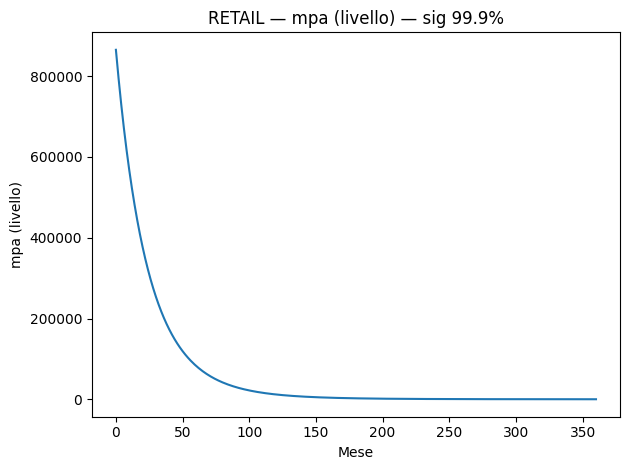

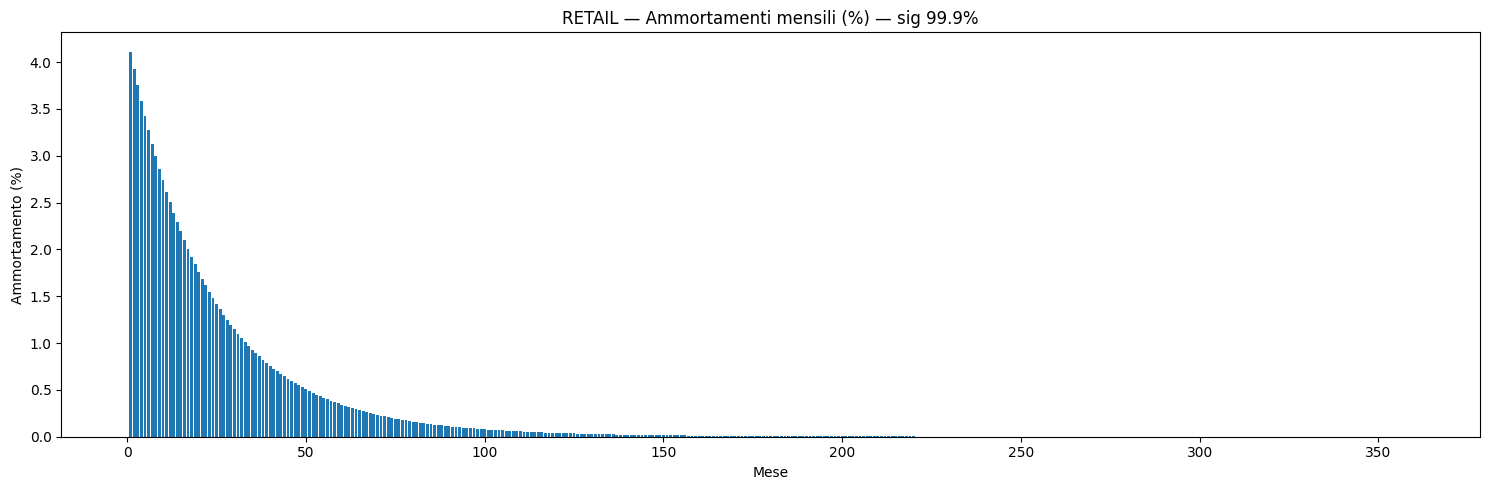


=== CORPORATE — significance 90.0% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,372549.716061,0.037516,0.9,0.99654,0.000582


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,372549.716061
1,1,0.031267,0.031267,0.000003,0.031270,0.031270,360447.090472
2,2,0.030149,0.061416,0.000003,0.030151,0.061422,348777.480266
3,3,0.029073,0.090489,0.000003,0.029076,0.090498,337524.109165
12,12,0.021073,0.310077,0.000003,0.021076,0.310113,252527.915153
24,24,0.013912,0.513198,0.000003,0.013915,0.513269,173905.809418
36,36,0.009325,0.648341,0.000003,0.009328,0.648448,121595.659317
48,48,0.006343,0.739609,0.000003,0.006346,0.739751,86268.550357
60,60,0.004375,0.802134,0.000003,0.004378,0.802312,62066.819109


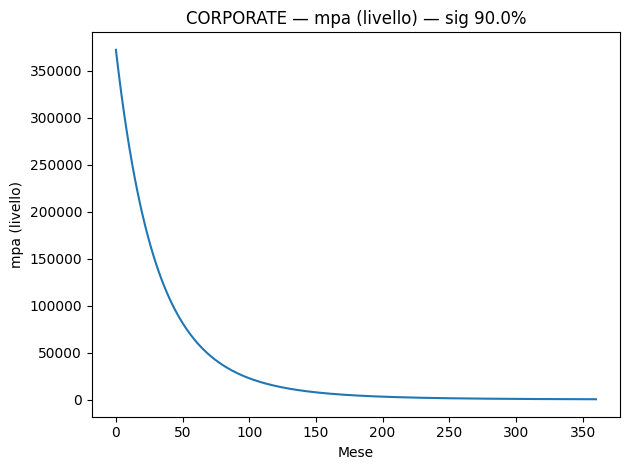

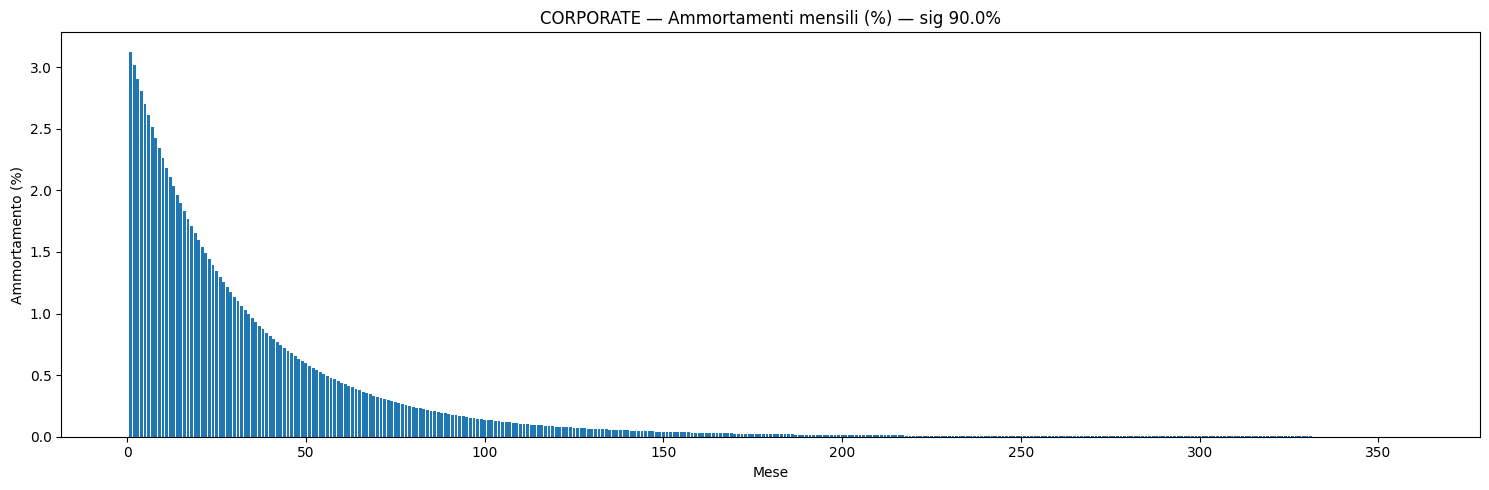


=== CORPORATE — significance 95.0% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,370049.283358,0.043976,0.95,0.99654,0.000582


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,370049.283358
1,1,0.039111,0.039111,4.860235e-07,0.039111,0.039111,354910.620170
2,2,0.037384,0.076495,4.860235e-07,0.037384,0.076495,340440.474373
3,3,0.035738,0.112233,4.860235e-07,0.035738,0.112234,326607.328893
12,12,0.023985,0.371400,4.860235e-07,0.023986,0.371406,226291.233676
24,24,0.014343,0.591282,4.860235e-07,0.014343,0.591293,141181.272482
36,36,0.008744,0.724049,4.860235e-07,0.008744,0.724066,89791.078457
48,48,0.005429,0.805743,4.860235e-07,0.005430,0.805766,58169.588635
60,60,0.003432,0.856930,4.860235e-07,0.003432,0.856959,38356.531934


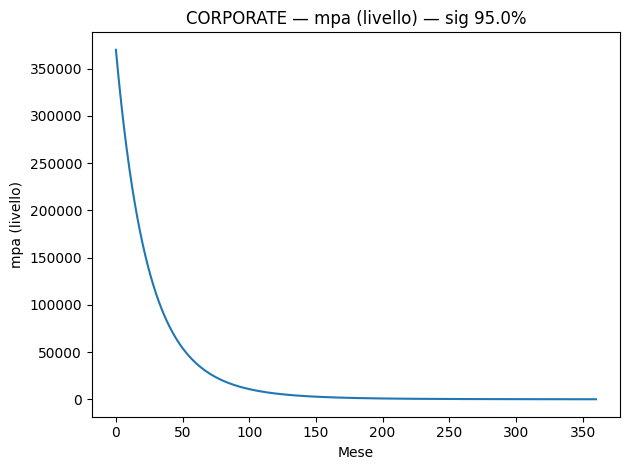

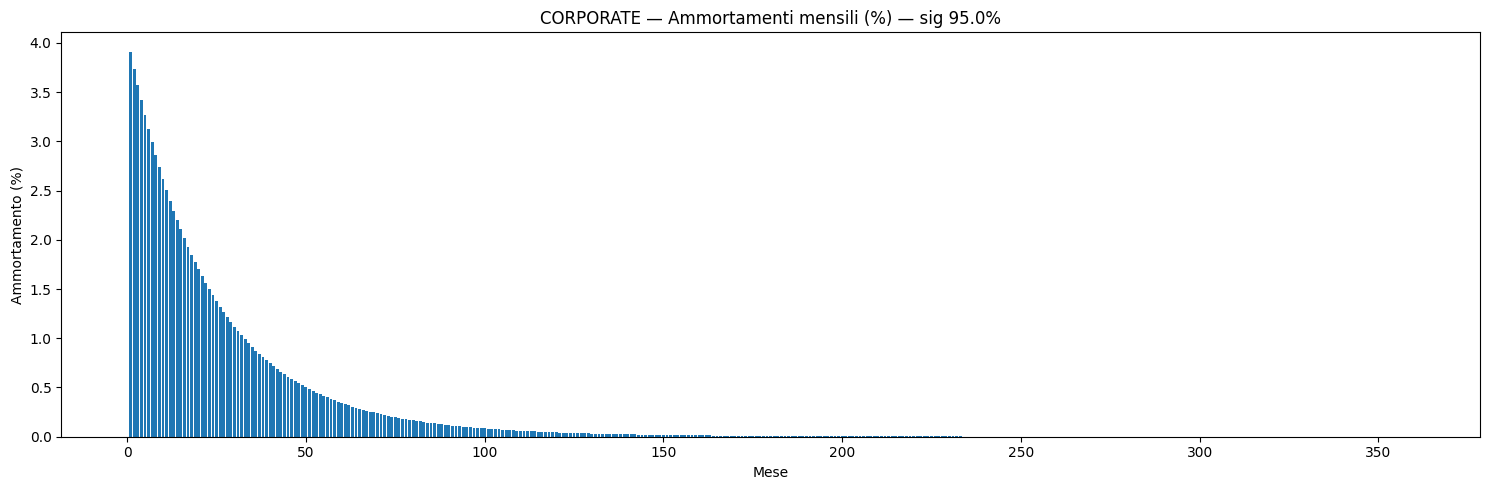


=== CORPORATE — significance 99.0% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,365404.064953,0.055977,0.99,0.99654,0.000582


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,365404.064953
1,1,0.053351,0.053351,1.634477e-08,0.053351,0.053351,344753.471962
2,2,0.050167,0.103518,1.634477e-08,0.050167,0.103518,325335.410410
3,3,0.047182,0.150700,1.634477e-08,0.047182,0.150700,307072.647368
12,12,0.027409,0.468130,1.634477e-08,0.027409,0.468131,184204.354802
24,24,0.013614,0.697332,1.634477e-08,0.013614,0.697332,95487.108056
36,36,0.006946,0.812675,1.634477e-08,0.006946,0.812676,50841.018881
48,48,0.003636,0.872270,1.634477e-08,0.003636,0.872270,27773.770901
60,60,0.001951,0.903848,1.634477e-08,0.001951,0.903849,15550.783763


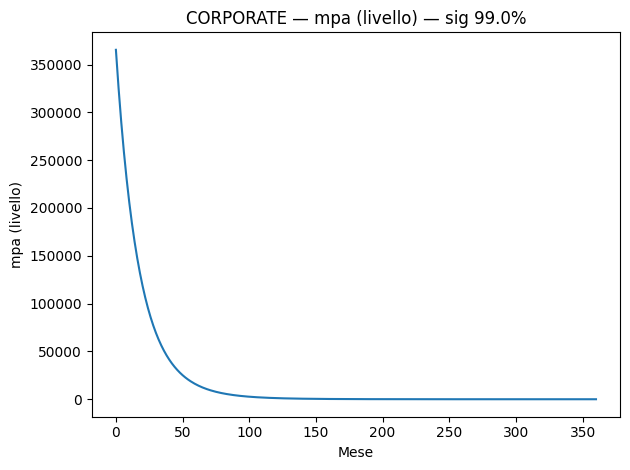

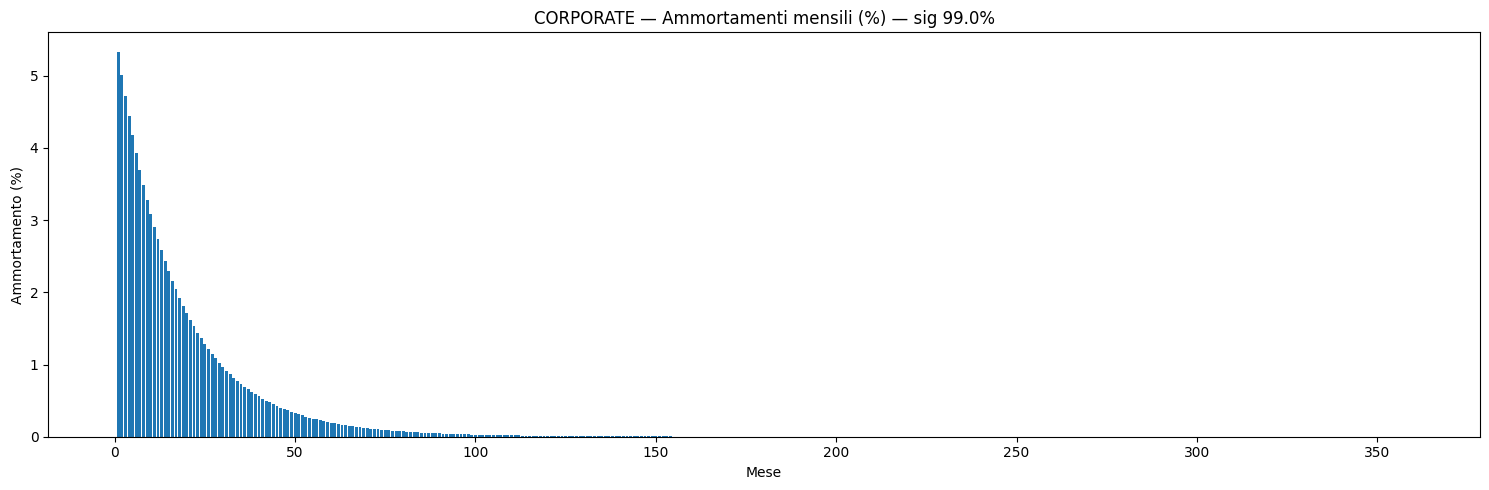


=== CORPORATE — significance 99.9% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,360266.533187,0.069249,0.999,0.99654,0.000582


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,ammortamento_pct_cum,mpa_livello
0,0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,360266.533187
1,1,0.068600,0.068600,3.647427e-10,0.068600,0.068600,333713.485333
2,2,0.063332,0.131932,3.647427e-10,0.063332,0.131932,309199.394480
3,3,0.058485,0.190417,3.647427e-10,0.058485,0.190417,286561.707418
12,12,0.028900,0.552885,3.647427e-10,0.028900,0.552885,146260.754236
24,24,0.011658,0.771607,3.647427e-10,0.011658,0.771607,61599.937706
36,36,0.004872,0.861322,3.647427e-10,0.004872,0.861322,26873.956391
48,48,0.002106,0.899420,3.647427e-10,0.002106,0.899420,12127.145163
60,60,0.000940,0.916146,3.647427e-10,0.000940,0.916147,5652.796203


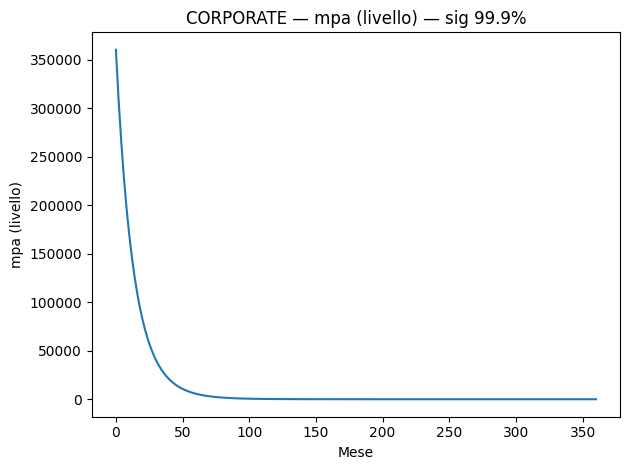

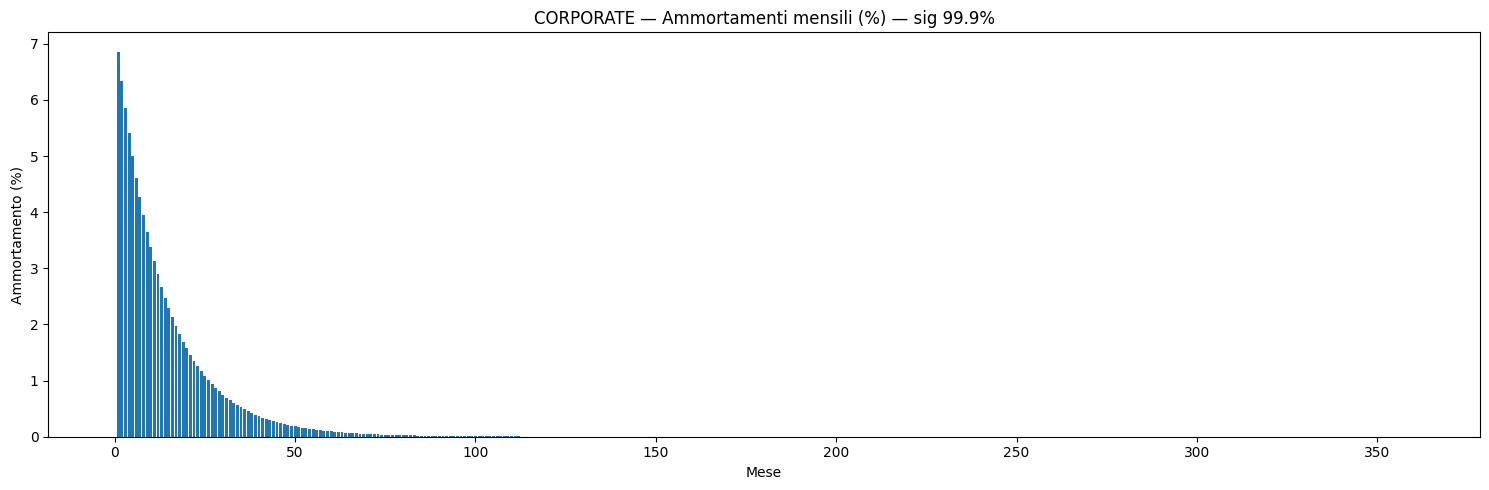

In [14]:
def stable_volatile_and_mpa(v_log: np.ndarray,
                            xs: np.ndarray,
                            Ps: np.ndarray,
                            beta: float,
                            Q: float,
                            horizons: int = 360,
                            significance: float = 0.99):
    """
    Calcola:
      - stable_T (livello) e quota volatile l_T
      - profilo mpa su 'horizons' mesi
      - ammortamenti mensili in % del volume corrente VT
    Ritorna (summary_df, schedule_df).
    """
    assert 0.5 < significance < 1.0, "significance deve essere in (0.5,1)."
    q = norm.ppf(1 - significance)  # < 0
    vbar = float(np.mean(v_log))
    VT = float(np.exp(v_log[-1]))

    piT = float(xs[-1])
    deltaT = float(np.sqrt(Ps[-1]))
    s_lb = piT + deltaT * q

    stable_T = float(np.exp(vbar + s_lb))
    l_T = float(1.0 - stable_T / VT)
    l_T = float(np.clip(l_T, 0.0, 1.0))

    # Dinamica mpa in log-stato
    s_path = [s_lb]
    for _ in range(1, horizons + 1):
        s_next = beta * s_path[-1] + np.sqrt(Q) * q
        s_path.append(s_next)
    s_path = np.array(s_path)                 # len = horizons+1 (include h=0)
    mpa = np.exp(vbar + s_path)               # livello
    QC = mpa[:-1] - mpa[1:]                   # deflusso in livello
    qc_pct = np.clip(QC / VT, 0.0, None)
    qc_pct_cum = np.cumsum(qc_pct)      # cumulato

    resid = float(max(0.0, 1.0 - l_T - qc_pct.sum()))
    even = resid / horizons if horizons > 0 else 0.0
    amm_pct = qc_pct + even
    amm_pct_cum = np.cumsum(amm_pct)

    summary = pd.DataFrame({
        "VT_livello": [VT],
        "stable_T_livello": [stable_T],
        "quota_volatile_l_T": [l_T],
        "significance": [significance],
        "beta": [beta],
        "Q": [Q]
    })

    schedule = pd.DataFrame({
        "h_mese": np.arange(1, horizons + 1, dtype=int),
        "qc_pct": qc_pct,
        "qc_pct_cum": qc_pct_cum,
        "residuale_uniforme_pct": even,
        "ammortamento_pct": amm_pct,
        "ammortamento_pct_cum": amm_pct_cum,
        "mpa_livello": mpa[1:]
    })

    # Aggiungi riga iniziale con stable_T
    initial_row = pd.DataFrame({
        "h_mese": [0],
        "qc_pct": [0.0],
        "qc_pct_cum": [0.0],
        "residuale_uniforme_pct": [0.0],
        "ammortamento_pct": [0.0],
        "ammortamento_pct_cum": [0.0],
        "mpa_livello": [stable_T]
    })
    schedule = pd.concat([initial_row, schedule], ignore_index=True)

    return summary, schedule

# --- Parametri e run ---
HOLDING_PERIOD = 360
SIGNIFICANCES = (0.9,0.95,0.99,0.999) #(0.90, 0.95, 0.99)

def run_step4_for(series_name, step2_df, res,show_months=(0, 1, 2, 3, 12, 24, 36, 48,60)):
    v_log = step2_df["v_log"].values.astype(float)
    xs = res.xs
    Ps = res.Ps
    beta = res.params.beta
    Q = res.params.Q

    

    # Pulizia/ordinamento mesi da mostrare
    show_months = sorted(set(int(m) for m in show_months if m is not None))  # Rimosso il filtro m > 0

    outputs = {}
    for sig in SIGNIFICANCES:
        summary, schedule = stable_volatile_and_mpa(
            v_log=v_log, xs=xs, Ps=Ps, beta=beta, Q=Q,
            horizons=HOLDING_PERIOD, significance=sig
        )
        outputs[sig] = {"summary": summary, "schedule": schedule}

        
        print(f"\n=== {series_name} — significance {(sig*100)}% ===")
        display(summary)
        
         # Filtro delle righe richieste, rispettando l'ordine in show_months
        # (ed escludendo mesi oltre l'orizzonte calcolato)
        valid_months = [m for m in show_months if m <= HOLDING_PERIOD]
        if valid_months:
            sel = schedule[schedule["h_mese"].isin(valid_months)].copy()
            # preserva l'ordine richiesto dall'utente
            sel["__ord__"] = pd.Categorical(sel["h_mese"], categories=valid_months, ordered=True)
            sel = sel.sort_values("__ord__").drop(columns="__ord__")
            display(sel)
        else:
            # fallback: se la lista è vuota o fuori orizzonte, mostra i primi 10 mesi
            display(schedule.head(10))

        # Grafico rapido del profilo mpa (livello)
        plt.figure()
        plt.plot(schedule["h_mese"], schedule["mpa_livello"])
        plt.title(f"{series_name} — mpa (livello) — sig {(sig*100)}%")
        plt.xlabel("Mese"); plt.ylabel("mpa (livello)")
        plt.tight_layout(); plt.show()

        # Barplot degli ammortamenti mensili
        plt.figure(figsize=(15, 5))
        plt.bar(schedule["h_mese"], schedule["ammortamento_pct"] * 100)
        plt.title(f"{series_name} — Ammortamenti mensili (%) — sig {(sig*100)}%")
        plt.xlabel("Mese")
        plt.ylabel("Ammortamento (%)")
        plt.tight_layout(); plt.show()

    return outputs

retail_step4 = run_step4_for("RETAIL", retail_step2, retail_res)
corporate_step4 = run_step4_for("CORPORATE", corporate_step2, corporate_res)

In [16]:
# --- Calcolo durata media della componente stabile (Average Life) ---

def mean_life_stable_from_schedule(schedule: pd.DataFrame) -> float:
    """
    Restituisce la durata media (in anni) della componente stabile
    usando SOLO i deflussi QC_h = mpa_{h-1} - mpa_{h}.
    Richiede che 'schedule' contenga la colonna 'mpa_livello'.
    """
    mpa = schedule["mpa_livello"].values

    if len(mpa) < 2:
        return np.nan
    QC = mpa[:-1] - mpa[1:]        # deflussi della sola parte stabile
    QC = np.clip(QC, 0.0, None)

    if QC.sum() <= 0:
        return 0.0
    h = np.arange(1, len(QC)+1, dtype=float)  # mesi 1..H
    durata_mesi = float((h * QC).sum() / QC.sum())
    return durata_mesi / 12.0  # anni

def summarize_mean_life(step4_bundle: dict, label: str):
    """
    step4_bundle: dict come quello restituito da run_step4_for / Step 4
                  {sig: {"summary":..., "schedule":..., ...}}
    Stampa una tabella (confidenza vs durata anni) per la componente stabile.
    """
    rows = []
    for sig, out in step4_bundle.items():
        sched = out["schedule"]
        dur = mean_life_stable_from_schedule(sched)
        rows.append({"Confidenza (%)": (sig*100), label: dur})
    df = pd.DataFrame(rows).sort_values("Confidenza (%)")
    return df

# --- ESEMPIO: durata media per Retail e Corporate alle confidenze calcolate ---
df_retail_dur = summarize_mean_life(retail_step4, "Retail")
df_corp_dur   = summarize_mean_life(corporate_step4, "Corporate")

# (Opzionale) merge delle due tabelle in un’unica vista
df_dur = pd.merge(df_retail_dur, df_corp_dur, on="Confidenza (%)", how="outer").sort_values("Confidenza (%)")
display(df_dur)

,Confidenza (%),Retail,Corporate
0,90.0,5.016802,2.869954
1,95.0,4.045625,2.230080
2,99.0,2.883455,1.569466
3,99.9,2.154315,1.183049
